# Web Scraping with requests and Beautiful Soup

#### Imports Statements

In [1]:
import requests
from bs4 import BeautifulSoup as bs
from bs4 import Comment
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import random

#### Get URL

In [2]:
url= 'https://www.basketball-reference.com/players/s/simshe01.html'

#### Headers to not overload systems

In [3]:
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/100.0.4896.75 Safari/537.36",
    "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8",
    "Accept-Language": "en-US,en;q=0.5",
    "Referer": "http://example.com/previous-page",
    "Cookie": "session_id=your_session_id_here",
    "Connection": "keep-alive",
    "Cache-Control": "max-age=0"
}

#### Get responses from website and return status

In [4]:
response = requests.get(url, headers=headers)
status = response.status_code

#### Return weather you were able to scrap or not

In [5]:
if status == 200:
    page = response.text
    soup = bs(page)
    print("HTML Recieved!")
    
else:
    print(f"Oops! Received status code {status}")

HTML Recieved!


#### Print HTML if obtained

In [ ]:
print(soup.prettify())

## Create Pipeline

#### Create function for getting HTML Page

In [6]:
def get_web_page(url):
    # Headers
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/100.0.4896.75 Safari/537.36",
        "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8",
        "Accept-Language": "en-US,en;q=0.5",
        "Referer": "http://example.com/previous-page",
        "Cookie": "session_id=your_session_id_here",
        "Connection": "keep-alive",
        "Cache-Control": "max-age=0"
    }
    # Response and status saved
    response = requests.get(url, headers=headers)
    status = response.status_code
    
    # Return if HTML obtained
    if status == 200:
        return response.text
    else:
        print(f"Oops! Received status code {status}")
        return ""

#### Get URLS and pipline list ready

In [7]:
# URl
base = "https://www.basketball-reference.com"
url_start = f"{base}/players/"

# List of Info
pipeline_list = []

#### Get HTML and soup

In [8]:
html = get_web_page(url_start)
soup = bs(html, "html.parser")

#### Find hidden tags within HTML Comments and only keeps URL linked comments *--Used Help from ChatGPT*

In [9]:
# Finds all comments in HTML
comments = soup.find_all(string=lambda text: isinstance(text, Comment))

# Empty List
letter_links = []

# Loop through comments to only keep the ones with URLS and remove the rest
for c in comments:
    if '/players/' in c:
        comment_soup = bs(c, "html.parser")
        for a in comment_soup.select("a[href^='/players/']"):
            href = a.get("href")
            if href and len(href) == 11:
                letter_links.append(base + href)

# Print links found
print(f"Found {len(letter_links)} letter pages.")

Found 25 letter pages.


C:\ProgramData\Anaconda3\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


#### Gather all Player Links

In [10]:
# Empty List
player_links = []

# loop through links and get pages
for letter_url in letter_links:
    page = get_web_page(letter_url)
    soup = bs(page, "html.parser")

    # Get each player table
    for a in soup.select("th[data-stat='player'] a"):
        href = a.get("href")
        # Add url to player link
        if href:
            player_links.append(base + href)
    time.sleep(1)

# print
print(f"Collected {len(player_links)} player profile links.")

Collected 5372 player profile links.


#### Loop through 5 players and scrape each part of their stats

In [11]:
# Get random players
random.shuffle(player_links)

# Loop through first 5 players
for i, url in enumerate(player_links[:15]):
    
    # Get the HTML and soup of the player
    html = get_web_page(url)
    soup = bs(html, "html.parser")

    # Get name
    name = soup.find("h1").find("span").text.strip() if soup.find("h1") else "N/A"

    # Get p tags
    position_tag = soup.find("p")
    p_tags = soup.find_all("p")
    position = "N/A"
    weight = None

    # Converts each paragraph into text
    for p in p_tags:
        text = p.get_text(" ", strip=True)
    
        # Look for the Position
        if "Position:" in text:
            # Extract the position value only *got help from chatGPT
            position = (
                text.split("Position:")[1]
                .split("Shoots:")[0]
                .split("▪")[0]
                .strip()
            )
    
        # Look for the Weight
        if "lb" in text:
            spans = p.find_all("span")
            if len(spans) > 1:
                # Extract the weight value only
                weight_text = spans[1].text.strip()
                if "lb" in weight_text:
                    weight = int(weight_text.replace("lb", "").strip())


        # mp_per_g tag
        minute_tags = soup.find_all("td", {"data-stat": "mp_per_g"})
        # extract and convert to float
        minutes_played = [float(tag.text.strip()) for tag in minute_tags if tag.text.strip()]

        # pts_per_g tag
        ppg_tags = soup.find_all("td", {"data-stat": "pts_per_g"})
        # extract and convert to float
        points_per_game = [float(tag.text.strip()) for tag in ppg_tags if tag.text.strip()]
          
        # fta_per_g tag
        fta_tags = soup.find_all("td", {"data-stat": "fta_per_g"})
        # Create empty list
        free_throws = []
        # Loop throuhg the tag and add values to list * got help from chatGPT
        for tag in fta_tags:
            text = tag.text.strip()
            if text:  # skip empty cells
                try:
                    free_throws.append(float(text))
                except ValueError:
                    pass  # ignore non-numeric text
        # if no values resort to 0
        if not free_throws:
            free_throws = [0]

        # blk_per_g tag
        blk_tags = soup.find_all("td", {"data-stat": "blk_per_g"})
        # extract and convert to float *got help from chatGPT
        blocks = float(blk_tags[-1].text.strip()) if blk_tags and blk_tags[-1].text.strip() else 0
        
        # games total
        total_games = 0
        games_label = soup.find("span", {"class": "poptip", "data-tip": "Games"})
        if games_label:
            # find the p tag and get the total game
            p_tag = games_label.find_next("p").find_next("p")
            if p_tag and p_tag.text.strip().isdigit():
                total_games = int(p_tag.text.strip())

        # Create a big dictionary for each player with their corresponding stats
        player_dict = {
        "name": name,
        "position": position,
        "weight": weight,
        "minutes played": minutes_played,
        "points": points_per_game,
        "free_throws": free_throws,
        "blocks": blocks,
        "total_games": total_games
        }
        
    # Add to pipeline list
    pipeline_list.append(player_dict)
    if i % 1 == 0:
        print(f"Processed {i+1}/{len(player_links)} players...")
    
    # sleep between requests
    time.sleep(2)
print(f"\nTotal players scraped: {len(pipeline_list)}")
print(pipeline_list[:15])

Processed 1/5372 players...
Processed 2/5372 players...
Processed 3/5372 players...
Processed 4/5372 players...
Processed 5/5372 players...
Processed 6/5372 players...
Processed 7/5372 players...
Processed 8/5372 players...
Processed 9/5372 players...
Processed 10/5372 players...
Processed 11/5372 players...
Processed 12/5372 players...
Processed 13/5372 players...
Processed 14/5372 players...
Processed 15/5372 players...

Total players scraped: 15
[{'name': 'Dick Duckett', 'position': 'Point Guard', 'weight': 185, 'minutes played': [12.5, 12.5], 'points': [3.9, 3.9], 'free_throws': [0.8, 0.8], 'blocks': 0, 'total_games': 34}, {'name': 'Wendell Ladner', 'position': 'Small Forward', 'weight': 220, 'minutes played': [32.5, 29.8, 32.4, 27.5, 17.9, 18.2, 17.8, 24.5, 27.3, 21.2, 17.4, 26.3, 30.8, 22.4, 19.5, 27.5, 35.8, 14.2, 19.4, 11.7, 18.0, 18.0, 14.2, 35.8], 'points': [17.0, 14.2, 16.5, 12.2, 6.9, 5.9, 7.3, 8.5, 9.9, 6.8, 4.1, 11.6, 15.5, 8.6, 5.6, 12.2, 10.3, 7.2, 8.2, 4.3, 7.6, 7.5, 7

#### Start to move data to pandas df

In [12]:
# Convert player dictionaries to df
df = pd.DataFrame(pipeline_list)

# standardize column
df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]

#### Get averages for mp p ft and b

In [13]:
# change col names
for col, new_col in [
    ("minutes_played", "avg_minutes"),
    ("points", "avg_points"),
    ("free_throws", "avg_free_throws"),
    ("blocks", "avg_blocks")]:
    # get average * help from chatGPT
    if col in df.columns:
        df[new_col] = df[col].apply(
            # If value is a list and not empty, calculate the average
            lambda x: round(sum(x) / len(x), 1) if isinstance(x, list) and len(x) > 0
            # If value is a single number, convert it to float
            else round(float(x), 1) if x not in [None, 'NaN', ''] and not isinstance(x, list) else 0
        )
    # if nothing return 0
    else:
        df[new_col] = 0

#### Drop the old columns

In [22]:
# drop columns
for col in ["minutes_played", "points", "free_throws", "blocks"]:
    if col in df.columns:
        df.drop(columns=[col], inplace=True)

print("Taking data on these 15 players:")
df

Taking data on these 15 players:


,name,position,weight,total_games,avg_minutes,avg_points,avg_free_throws,avg_blocks
0,Dick Duckett,Point Guard,185,34,12.5,3.9,0.8,0.0
1,Wendell Ladner,Small Forward,220,300,23.3,9.4,1.3,0.0
2,Mark Bradtke,Center,265,36,7.0,1.6,0.4,0.1
3,Eddie Basden,Small Forward,215,19,7.4,2.1,0.5,0.1
4,Josh Howard,Small Forward,210,507,27.6,12.5,3.4,0.3
5,Matt Thomas,Shooting Guard,190,126,7.9,3.0,0.2,0.0
6,Rodney Rogers,Small Forward and Power Forward,235,866,23.3,9.4,2.3,1.0
7,Wayne Sappleton,Power Forward,215,33,9.0,2.9,1.0,0.1
8,LeBron James,"Small Forward, Power Forward, Point Guard, Cen...",250,1562,39.2,27.5,7.9,0.8
9,Quincy Acy,Power Forward and Small Forward,240,337,14.0,4.1,1.1,0.0


#### Seaborn Styles

In [15]:
sns.set(style="whitegrid")

### Question 1:
#### Create seaborn barplot

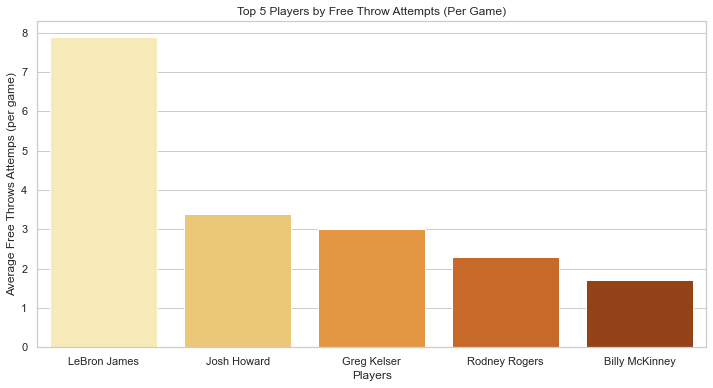

In [21]:
# Get top 5
top_5_players = df.nlargest(5, 'avg_free_throws')
# Create plot
plt.figure(figsize=(12, 6))
sns.barplot(x='name', y='avg_free_throws', data=top_5_players, palette="YlOrBr")
# Change title and axis
plt.title("Top 5 Players by Free Throw Attempts (Per Game)")
plt.xlabel("Players")
plt.ylabel("Average Free Throws Attemps (per game)")
plt.show()

### Question 2:
#### Create seaborn barplot

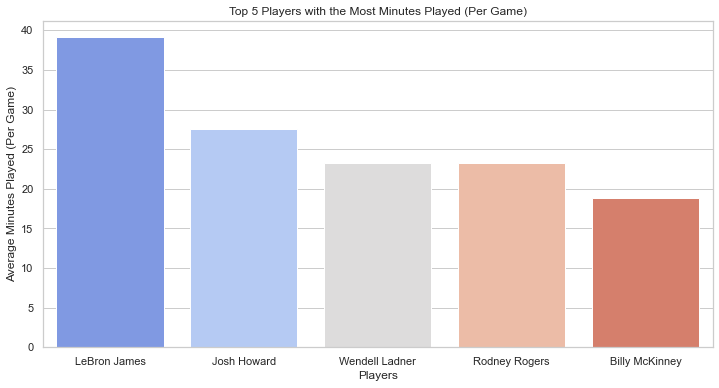

In [17]:
# Get top 5
top_5_minutes = df.nlargest(5, 'avg_minutes')
# Create Plot
plt.figure(figsize=(12, 6))
sns.barplot(x='name', y='avg_minutes', data=top_5_minutes, palette="coolwarm")
# Change title and axis
plt.title("Top 5 Players with the Most Minutes Played (Per Game)")
plt.xlabel("Players")
plt.ylabel("Average Minutes Played (Per Game)")
plt.show()

### Question 3:
#### Create seaborn barplot

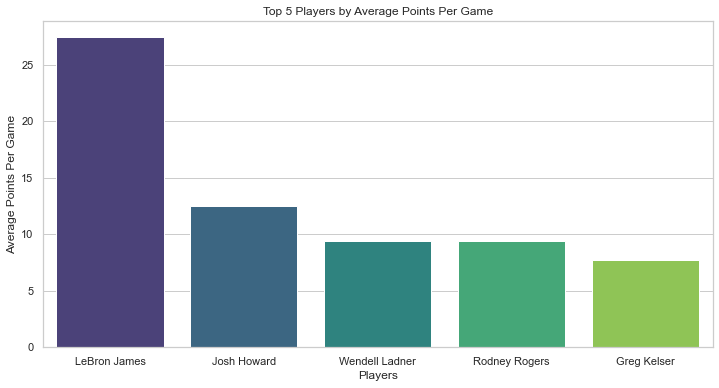

In [18]:
# Get top 5
top_5_points = df.nlargest(5, 'avg_points')
# Create plot
plt.figure(figsize=(12, 6))
sns.barplot(x='name', y='avg_points', data=top_5_points, palette="viridis")
# Change title and axis
plt.title("Top 5 Players by Average Points Per Game")
plt.xlabel("Players")
plt.ylabel("Average Points Per Game")
plt.show()

### Question 4:
#### Create seaborn barplot

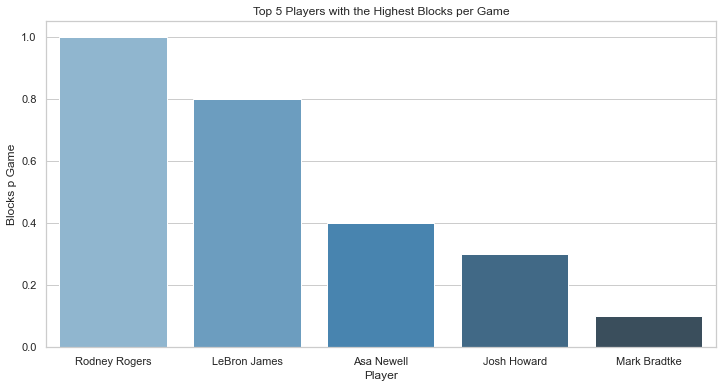

In [19]:
# Get top 5
top_5_blocks = df.nlargest(5, 'avg_blocks')
# Create plot
plt.figure(figsize=(12, 6))
sns.barplot(x='name', y='avg_blocks', data=top_5_blocks, palette="Blues_d")
# Change title and axis
plt.title("Top 5 Players with the Highest Blocks per Game")
plt.xlabel("Player")
plt.ylabel("Blocks p Game")
plt.show()

### Question 5:
#### Create seaborn barplot

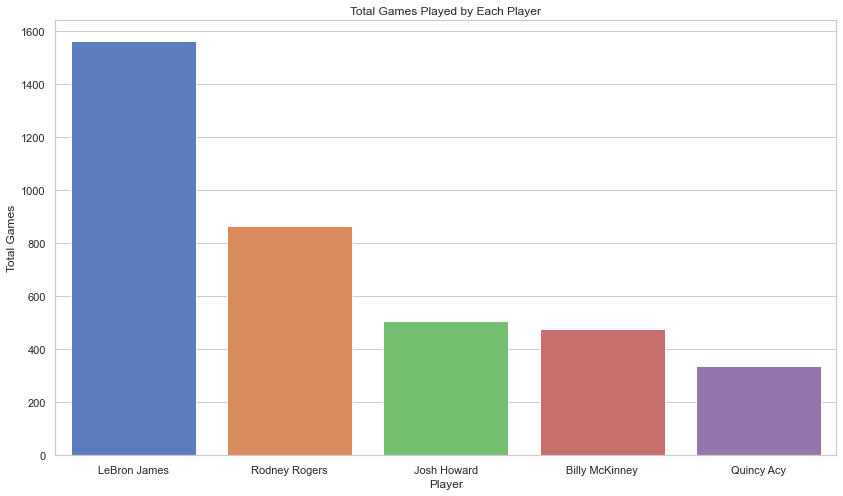

In [20]:
# Get top 5
top_5_games = df.nlargest(5, 'total_games')
# Create plot
plt.figure(figsize=(14, 8))
sns.barplot(x='name', y='total_games', data=top_5_games, palette="muted")
# Change title and axis
plt.title("Total Games Played by Each Player")
plt.xlabel("Player")
plt.ylabel("Total Games")
plt.show()
